In [1]:
# import pyodbc
import os
import urllib
import plotly.express as px

import pandas as pd
from sqlalchemy import create_engine

pd.set_option("display.max_columns", 500)

import itertools
from calendar import different_locale, month_name
from datetime import datetime as dt
from zipfile import ZipFile

import numpy as np
from dateutil.relativedelta import relativedelta

# mdb_to_df

In [2]:
def zip2mdb2df(data_type, sql, period):

    file_name = f"{period}-{data_type.lower()}"

    data_type_path = (
        f"../Availability_Warranty_Dash/monthly_data/uploads/{data_type.upper()}/"
    )

    ZipFile(f"{data_type_path}{file_name}.zip", "r").extractall(data_type_path)

    conn_str = (
        r"DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};"
        fr"DBQ={data_type_path}{file_name}.mdb;"
    )
    conn_str = f"access+pyodbc:///?odbc_connect={urllib.parse.quote_plus(conn_str)}"
    cnxn = create_engine(conn_str, echo=True)

    return pd.read_sql(sql, cnxn)



# Periods

In [3]:
def read_cnt_timestamp(period):
    sql_cnt = "Select TimeStamp, StationId FROM tblSCTurCount;"

    cnt = zip2mdb2df(data_type="CNT", sql=sql_cnt, period=period)

    cnt["TimeStamp"] = pd.to_datetime(cnt["TimeStamp"], format="%m/%d/%y %H:%M:%S")

    return cnt


def get_month_name(month_no, locale):
    with different_locale(locale):
        return month_name[month_no].capitalize()


In [4]:
period = input('period ex: "2020-07"') or "2023-12"

period_dt = dt.strptime(period, "%Y-%m")
period_month = period_dt.month
period_month_name = get_month_name(period_month, "french")
period_year = period_dt.year

previous_period_dt = period_dt + relativedelta(months=-1)
previous_period = previous_period_dt.strftime("%Y-%m")

lastday_period_dt = period_dt + relativedelta(months=1, days=-1)
lastday_period = lastday_period_dt.strftime("%Y-%m-%d")

lastday_previous_period_dt = period_dt + relativedelta(days=-1)
lastday_previous_period = lastday_previous_period_dt.strftime("%Y-%m-%d")

days_to_previous_period = len(
    pd.date_range(f"{period_year}-01-01", lastday_previous_period_dt)
)

currentMonth = dt.now().month
currentYear = dt.now().year
currentPeriod = f"{currentYear}-{str(currentMonth).zfill(2)}"
currentPeriod_dt = dt.strptime(currentPeriod, "%Y-%m")

cumul_start = pd.Timestamp(f"{period_year}-01-01 00:00:00.000")

cnt_timestamp = read_cnt_timestamp(period)
period_end = cnt_timestamp.TimeStamp.max()
# period_end = pd.Timestamp(f"2023-02-01 00:00:00.000")

days_in_cumul = (period_end - cumul_start).days

# days_in_cumul = len(
#     pd.date_range(f"{period_year}-01-01", f"{lastday_period}", freq="D")
# )

days_in_cumul, period_end


2024-01-26 18:00:01,209 INFO sqlalchemy.engine.Engine Select TimeStamp, StationId FROM tblSCTurCount;
2024-01-26 18:00:01,210 INFO sqlalchemy.engine.Engine [raw sql] ()


(365, Timestamp('2024-01-01 00:00:00'))

# Read SUM

In [5]:
def read_sum(period):
    alarms = pd.read_table(
        f"../Availability_Warranty_Dash/monthly_data/uploads/SUM/{period}-sum.rpt",
        sep="|",
        # skipfooter=2,
        # engine="python"
        # on_bad_lines="skip",
    )
    alarms.dropna(subset=["Alarmcode"], inplace=True)

    alarms["TimeOn"] = pd.to_datetime(alarms["TimeOn"], format="%Y-%m-%d %H:%M:%S.%f")
    alarms["TimeOff"] = pd.to_datetime(alarms["TimeOff"], format="%Y-%m-%d %H:%M:%S.%f")

    alarms = alarms[(alarms.StationNr >= 2307405) & (alarms.StationNr <= 2307535)].reset_index(
        drop=True
    )
    alarms.reset_index(drop=True, inplace=True)
    alarms["Alarmcode"] = alarms.Alarmcode.astype(int)
    alarms["Parameter"] = alarms.Parameter.str.replace(" ", "").fillna("")

    return alarms


In [6]:
alarms = pd.DataFrame()

for month in range(1, period_month+1): # range(1, period_month+1):

    period_cumul = f'{str(period_year).zfill(2)}-{str(month).zfill(2)}'

    # -------------------------------------------------------------------------
    period_alarms = read_sum(period_cumul)
    alarms = pd.concat([alarms, period_alarms])

alarms.rename(columns={"StationNr": "StationId"}, inplace=True)
alarms["StationId"] = alarms["StationId"] - 2307404

alarms.reset_index(drop=True)
alarms.drop_duplicates(inplace=True, keep="last", subset=["ID"])
# -------Copy period_alarms to calculate mtti before remove 50000 period_alarms before period----------
alarm_50000 = alarms.query("Alarmcode == 50000").copy()

In [7]:
alarms.sort_values("TimeOn")

,TimeOn,TimeOff,StationId,Alarmcode,Parameter,ID
1715,2022-12-12 18:08:58,2023-01-06 17:14:15,94.0,64101,,7514296.0
1717,2022-12-12 18:20:13,2023-01-12 10:12:09,43.0,64101,,7514622.0
1716,2022-12-12 18:20:13,2023-01-04 10:32:52,64.0,64101,,7514616.0
4175,2022-12-15 20:39:06,2023-01-04 05:32:29,99.0,13309,,7548141.0
837,2022-12-16 16:26:00,2023-01-02 11:14:32,25.0,15207,,7556873.0
...,...,...,...,...,...,...
192758,2024-01-01 12:13:04,NaT,41.0,1001,,9578680.0
192759,2024-01-01 12:13:05,NaT,41.0,1005,,9578682.0
192762,2024-01-01 12:18:11,NaT,27.0,63025,,9578710.0
192763,2024-01-01 12:19:55,NaT,5.0,1001,,9578713.0


# Cascade

In [8]:
# Determine alarms real periods
def cascade(df):
    df.reset_index(inplace=True, drop=True)
    df["TimeOffMax"] = df.TimeOff.cummax().shift()

    df.at[0, "TimeOffMax"] = df.at[0, "TimeOn"]

    return df


# looping through turbines and applying cascade method
def apply_cascade(result_sum):
    # Sort by alarm ID
    df = result_sum.sort_values(["ID"]).groupby("StationId").apply(cascade)

    mask_root = df.TimeOn.values >= df.TimeOffMax.values
    mask_children = (df.TimeOn.values < df.TimeOffMax.values) & (
        df.TimeOff.values > df.TimeOffMax.values
    )
    mask_embedded = df.TimeOff.values <= df.TimeOffMax.values

    df.loc[mask_root, "NewTimeOn"] = df.loc[mask_root, "TimeOn"]
    df.loc[mask_children, "NewTimeOn"] = df.loc[mask_children, "TimeOffMax"]
    df.loc[mask_embedded, "NewTimeOn"] = df.loc[mask_embedded, "TimeOff"]

    df.drop(columns=["TimeOffMax"], inplace=True)

    df.reset_index(inplace=True, drop=True)

    df["RealPeriod"] = abs(df.TimeOff - df.NewTimeOn)

    df["Period Siemens(s)"] = df[df["Error Type"] == 1].RealPeriod  # .dt.seconds
    df["Period Tarec(s)"] = df[df["Error Type"] == 0].RealPeriod  # .dt.seconds
    # df['RealPeriod(s)'] = df['RealPeriod']#.dt.seconds

    return df

# Import last period cumul

In [9]:
df_last_ax1 = pd.read_excel(
    f'./results/{previous_period}/TB Performance {previous_period}.xlsx',
    sheet_name='KPIs',
    index_col=0)

last_boost_cumul = df_last_ax1.at['Indicateurs annuels :', 'Power Boost en MWh']
last_ratio_cumul = df_last_ax1.at['Indicateurs annuels :', 'Performance moyenne des turbines']
last_mtbf_cumul = df_last_ax1.at['Indicateurs annuels :', 'MTBF - Mean Time Between Failure']
last_mttr_cumul = df_last_ax1.at['Indicateurs annuels :', 'MTTR - Mean Time To Repair']
last_mtti_cumul = df_last_ax1.at['Indicateurs annuels :', 'MTTI - Mean Time To Intervention']
last_onee_cumul = df_last_ax1.at['Indicateurs annuels :', 'Compteurs ONEE MWh']

In [10]:
df_last_ax1

,LTA-Lost Time,Indispo. Energie Total %,Indispo. Energie Tarec %,Indispo. Energie Siemens %,Indispo. Temps Total %,Indispo. Temps Tarec %,Indispo. Temps Siemens %,Indispo. Temps ONEE %,Indispo. Temps Ebop %,Pertes élctriques en MWh,Power Boost en MWh,Performance moyenne des turbines,MTBF - Mean Time Between Failure,MTTR - Mean Time To Repair,MTTI - Mean Time To Intervention,Compteurs ONEE MWh
Indicateurs annuels :,0,3.08,0.23,2.85,4.02,1.24,2.78,0,0,20827.17,11323.58,103.9,39.14,11.87,5.68,1041156.55
Indicateurs du mois 2023-11 :,0,4.06,0.20,3.85,4.37,0.91,3.46,0,0,1577.44,899.62,102.6,52.28,19.94,5.56,74010.13


# ONEE

In [11]:
onee_tah = pd.read_excel(
    f'./input/{period}/CCH TAREC TAH {period}.xlsx')
onee_nord = pd.read_excel(
    f'./input/{period}/CCH TAREC NORD {period}.xlsx')

onee = pd.concat([onee_tah, onee_nord])

onee_received = onee['kWh-Rec'].sum()/6/1e3
onee_received

58702.27

In [ ]:
onee.groupby(['Date', 'Time']).sum()['kWh-Del'].max()

In [12]:
# 95172.63

onee_period = float(input("onee_period") or onee_received)

if period_month == 1:
    onee_cumul = onee_period
else:
    onee_cumul = last_onee_cumul + onee_period


# Init

## Processing alarms

In [13]:
# abbreviations
Frame = pd.DataFrame
c1 = "Alarmcode"
c2 = "Error Group"

error_group = pd.concat(
    [
        Frame({c1: range(901, 2101), c2: "System"}),
        Frame({c1: range(2101, 3000), c2: "Generator"}),
        Frame({c1: range(3100, 4000), c2: "Hub"}),
        Frame({c1: range(4100, 5000), c2: "Gear"}),
        Frame({c1: range(5000, 6000), c2: "Grid"}),
        Frame({c1: range(6100, 7000), c2: "Rotor"}),
        Frame({c1: range(7100, 8000), c2: "Hydraulics"}),
        Frame({c1: range(8000, 8400), c2: "Environement"}),
        Frame({c1: range(8450, 9000), c2: "Turbine cond..."}),
        Frame({c1: range(9100, 10000), c2: "Brake"}),
        Frame({c1: range(10100, 11000), c2: "Yaw"}),
        Frame({c1: range(11100, 12000), c2: "PFC"}),
        Frame({c1: range(12100, 13000), c2: "Transformer"}),
        Frame({c1: range(13000, 14000), c2: "Converter-1"}),
        Frame({c1: range(14000, 15000), c2: "Gen.inverter"}),
        Frame({c1: range(15000, 16000), c2: "Grid inverter"}),
        Frame({c1: range(16000, 17000), c2: "Main bearing"}),
        Frame({c1: range(17000, 18300), c2: "Converter-2"}),
        Frame({c1: range(62001, 64000), c2: "Controller"}),
        Frame({c1: range(64000, 65200), c2: "MISCELLANEOUS"}),
    ]
)


In [14]:
reorder = [
    "System",
    "Generator",
    "Hub",
    "Gear",
    "Grid",
    "Rotor",
    "Hydraulics",
    "Environement",
    "Turbine cond...",
    "Brake",
    "Yaw",
    "PFC",
    "Transformer",
    "Converter-1",
    "Gen.inverter",
    "Grid inverter",
    "Main bearing",
    "Converter-2",
    "Controller",
    "MISCELLANEOUS",
]


In [15]:
error_list = pd.read_excel(
    r"../Availability_Warranty_Dash/Alarmes List Norme RDS-PP_Tarec.xlsx", usecols=lambda x: x != "Type Selected"
)

error_list.rename(columns={"Number":"Alarmcode"}, inplace=True)

error_list.Alarmcode = error_list.Alarmcode.astype(int)  # ,errors='ignore'

error_list.drop_duplicates(subset=["Alarmcode"], inplace=True)

error_list = error_list.merge(error_group, on="Alarmcode", how="left")
alarms_0_1 = error_list.loc[error_list["Error Type"].isin([1, 0])].Alarmcode


In [16]:
# ------------------------------Fill NA TimeOff-------------------------------------
def process_alarms(alarms, period_start, period_end):
    period_alarms = alarms.copy()

    # period_alarms["OldTimeOn"] = period_alarms["TimeOn"]
    # period_alarms["OldTimeOff"] = period_alarms["TimeOff"]

    print(
        f"TimeOff NAs = {period_alarms.loc[period_alarms.Alarmcode.isin(alarms_0_1)].TimeOff.isna().sum()}"
    )

    if period_alarms.loc[period_alarms.Alarmcode.isin(alarms_0_1)].TimeOff.isna().sum():
        print(
            f"earliest TimeOn when TimeOff is NA= \
            {period_alarms.loc[period_alarms.Alarmcode.isin(alarms_0_1) & period_alarms.TimeOff.isna()].TimeOn.min()}"
        )

    period_alarms.loc[period_alarms.Alarmcode.isin(alarms_0_1), "TimeOff"] = period_alarms.loc[
        period_alarms.Alarmcode.isin(alarms_0_1), "TimeOff"
    ].fillna(period_end)

    # ------------------------------Alarms ending after period end --------------------------

    period_alarms.loc[(period_alarms.TimeOff > period_end), "TimeOff"] = period_end

    # ------------------------------Keep only period_alarms active in period------------------------
    period_alarms.reset_index(inplace=True, drop=True)
    # ----dropping 1 0 period_alarms
    period_alarms.drop(
        period_alarms.query(
            "(TimeOn < @period_start) & (TimeOff < @period_start) & Alarmcode.isin(@alarms_0_1)"
        ).index,
        inplace=True,
    )

    period_alarms.drop(
        period_alarms.query("(TimeOn > @period_end)").index,
        inplace=True,
    )
    period_alarms.reset_index(drop=True, inplace=True)
    # ------------------------------Alarms starting before period start --------------------------

    period_alarms.loc[
        (period_alarms.TimeOn < period_start) & (period_alarms.Alarmcode.isin(alarms_0_1)),
        "TimeOn",
    ] = period_start

    # ----dropping non 1 0 period_alarms
    period_alarms.drop(
        period_alarms.query("~Alarmcode.isin(@alarms_0_1) & (TimeOn < @period_start)").index,
        inplace=True,
    )
    period_alarms.reset_index(drop=True, inplace=True)

    period_alarms = pd.merge(period_alarms, error_list, on="Alarmcode", how="left", sort=False)

    # ------------------------------------------
    """ label scada alarms with coresponding error type
    and only keep alarm codes in error list"""

    # Remove warnings
    result_sum = period_alarms.loc[period_alarms["Error Type"].isin([1, 0])].copy()

    # Determine alarms real periods applying cascade method

    # apply cascade
    alarms_result_sum = apply_cascade(result_sum)
    # alarms_result_sum.RealPeriod.clip(
    #     upper=pd.Timedelta(f"{days_in_period} day"), inplace=True
    # )
    # only keep  parent alarms
    parent_result_sum = alarms_result_sum.query("TimeOn == NewTimeOn")

    # dash duree
    main_result_sum = alarms_result_sum.query("RealPeriod > @pd.Timedelta(0)", engine="python")
    # main_result_sum['ALL duree'] = main_result_sum['TimeOff'] -main_result_sum['TimeOn']

    return period_alarms, result_sum, alarms_result_sum, parent_result_sum, main_result_sum


# warning_date = period_alarms.TimeOn.min()

## MTBF MTTR 

In [17]:
manual_stop = [
    1001,
    1002,
    1005,
    1007,
    1008,
    1009,
    1015,
    1016,
    1017,
    1021,
    1025,
    1026,
    1027,
    8216,
    8217,
    8222,
]
mt_query = '(Alarmcode not in @manual_stop) & (RealPeriod >= @pd.Timedelta("2H"))'

## MTTI

In [18]:
def mtti(df, turbine, alarms, alarm_50000):
    # df = main_result_sum.query("StationId == @turbine")

    df = pd.concat(
        [
            (
                df.loc[
                    (df.TimeOn == df.NewTimeOn).shift(-1).fillna(True)
                ]  # mask root alarms then shift by -1, to flag the alarm before the root alarms,
                # since we have shifted the values by -1 we have to fill the last value,
                # we fill with True to check afterwards if its tail alarm
                .query(
                    "TimeOn != NewTimeOn"
                )  # when shifting  by -1 the alarm before a root alarm could also be a root alarm,
                # so we keep non root alarms which in this case are the tail alarms in a chain of alarms
                .assign(root=False)
            ),
            df.query("TimeOn == NewTimeOn").assign(root=True),
        ]  # query root alarms and assign them the value True beofre appending them to the tail alarms
    ).sort_values("ID")
    # Important step to restore the order of the alarms

    # results: after this operation we only keep first(root) alarms and tail alarms in a chain,
    #  consequently all alarms in between are removed.

    # mask for tail alarms then shift by -1 to select every root alarm that has a following tail alarm
    # fill last value with False because its either a tail alarm or a root alarm without a tail alarm
    root_alarms_with_tail_alarms = (df.root == False).shift(-1).fillna(False)

    # then replace the TimeOff of root alarms with tail alarms with the TimeOff of its coresponding tail alarm (order is important)
    df.loc[root_alarms_with_tail_alarms, "TimeOff"] = df.loc[(df.root == False), "TimeOff"].values

    # to flatten the alarms => Stop duration = Tail_TimeOff - Root_TimeOn
    df["RealPeriod"] = df["TimeOff"] - df["NewTimeOn"]

    # drop these columns because theay are not updated after recalculationg RealPeriod

    df.drop(columns=["Period Tarec(s)", "Period Siemens(s)"], inplace=True)

    # drop tail after flattening the alarms
    df.drop(df.loc[df.root == False].index, inplace=True)

    # --------------------------------------------------------

    df2 = alarm_50000.query("StationId == @turbine & Alarmcode == 50000")

    # append 50000 warning "Service mode"
    df = pd.concat([df2, df]).sort_values("TimeOn").reset_index(drop=True)

    df = df.query("Alarmcode not in @manual_stop")

    # Flag 50000 alarms and non 50000 alarms
    df.loc[(df["Alarmcode"] != 50000), "50000"] = False
    df.loc[(df["Alarmcode"] == 50000), "50000"] = True

    # Remove consecutive alarms and keep the last one => shift(-1) with !=(non 50000 alarm)
    ## Visualise operation in excel table then shift and compare
    df_alarms = df.loc[(df["50000"].shift(-1) != df["50000"]) & (df["50000"] == False)]

    # Remove consecutive alarms with same alarmcode and keep the first one (50000 alarm)
    df_50000 = df.loc[(df["50000"].shift() != df["50000"]) & (df["50000"] == True)]

    df = pd.concat([df_alarms, df_50000]).sort_values("TimeOn").reset_index(drop=True)

    # --------------------------------------------------------
    df = cascade(df)

    mask_root = df.TimeOn.values >= df.TimeOffMax.values

    mask_children = (df.TimeOn.values < df.TimeOffMax.values) & (
        df.TimeOff.values > df.TimeOffMax.values
    )
    mask_embedded = df.TimeOff.values <= df.TimeOffMax.values

    df["NewTimeOn"].mask(mask_root, df["TimeOn"], inplace=True)

    df["NewTimeOn"].mask(mask_children, df["TimeOffMax"], inplace=True)

    df["NewTimeOn"].mask(mask_embedded, df["TimeOff"], inplace=True)

    # drop 50000 alarms that are not children or embedded in another alarm,
    # it could be because they were after a manual stop,
    # which we don take into consideration when calculationg MTTI
    df.drop(df.query("TimeOn == NewTimeOn & Alarmcode == 50000").index, inplace=True)

    # --------------------------------------------------------

    # mask for 50000 alarms then shift by -1 to get the previous alarm
    mask = (df.Alarmcode == 50000).shift(-1, fill_value=False)

    # give the alarm preceding a 50000 alarm the TimeOn of the 50000 alarms
    # since we only kept child and embedded 50000 alarms,
    # theres is always a root alarm before a 50000
    df.loc[mask, "InterTimeOn"] = df.loc[(df.Alarmcode == 50000), "TimeOn"].values

    # Get the time of the intervention of each alarm that have a 50000 alarm after it
    df.loc[mask, "TimeTI"] = df.loc[mask, "InterTimeOn"] - df.loc[mask, "TimeOn"]

    df["TimeTI"] = df["TimeTI"].astype("timedelta64[ns]")
    return df

# Calcul Cumul

In [19]:
cumul_results = pd.DataFrame()

for month in range(1, period_month + 1):  # range(1, period_month+1):
    period_cumul = f"{str(period_year).zfill(2)}-{str(month).zfill(2)}"

    # -------------------------------------------------------------------------
    results = pd.read_pickle(f"../DATA/results/{period_cumul}.pkl")

    # results = results[['StationId', 'ELNX', 'Duration 115(s)', 'Duration 20-25(s)',
    #                    'Period 0(s)', 'Period 1(s)', 'RealPeriod',
    #                    'EL_indefini_left']]
    cumul_results = pd.concat([cumul_results, results])

cumul_results.sort_values(["StationId", "TimeStamp"], inplace=True)
cumul_results.reset_index(drop=True, inplace=True)
cumul_results["StationId"] = cumul_results["StationId"] - 2307404
results["StationId"] = results["StationId"] - 2307404

In [20]:
(
    cumul_alarms,
    cumul_result_sum,
    cumul_alarms_result_sum,
    cumul_parent_result_sum,
    cumul_main_result_sum,
) = process_alarms(alarms, cumul_start, period_end)


TimeOff NAs = 43
earliest TimeOn when TimeOff is NA=             2023-09-27 12:55:51


## Indispo

### indispo cumul

In [21]:
Ep_cumul = cumul_results["wtc_kWG1TotE_accum"].sum()
EL_cumul = cumul_results["EL"].sum()
ELX_cumul = cumul_results["ELX"].sum()
ELNX_cumul = cumul_results["ELNX"].sum()
EL_2006_cumul = cumul_results["EL_2006"].sum()
EL_PowerRed_cumul = cumul_results["EL_PowerRed"].sum()
EL_Misassigned_cumul = cumul_results["EL_Misassigned"].sum()

ELX_eq_cumul = ELX_cumul - EL_Misassigned_cumul
ELNX_eq_cumul = ELNX_cumul + EL_2006_cumul + EL_PowerRed_cumul + EL_Misassigned_cumul
Epot_eq_cumul = Ep_cumul + ELX_eq_cumul + ELNX_eq_cumul

Epot_cumul = cumul_results["Epot"].sum()

EL_wind_cumul = cumul_results["EL_wind"].sum()
EL_wind_start_cumul = cumul_results["EL_wind_start"].sum()
EL_alarm_start_cumul = cumul_results["EL_alarm_start"].sum()

MAA_cumul_brut = round(
    100
    * (Ep_cumul + ELX_cumul + EL_PowerRed_cumul)
    / (Ep_cumul + ELX_cumul + ELNX_cumul + EL_2006_cumul + EL_PowerRed_cumul),
    2,
)

MAA_cumul_brut_mis = round(100 * (Ep_cumul + ELX_eq_cumul) / (Epot_eq_cumul), 2)

In [22]:
Epot_eq_cumul , Epot_cumul

(1160598134.151651, 1155057716.004103)

In [23]:
MAA_cumul_brut, MAA_cumul_brut_mis

(97.14, 96.96)

In [24]:
(
    round(Ep_cumul / 1e3, 2),
    round(ELX_eq_cumul / 1e3, 2),
    round(ELNX_eq_cumul / 1e3, 2),
    round(EL_PowerRed_cumul / 1e3, 2),
    round(Epot_eq_cumul / 1e3, 2),
)

(1121845.88, 3508.45, 35243.81, 885.43, 1160598.13)

In [25]:
(
    round(100 * (ELX_eq_cumul) / (Epot_eq_cumul), 2),
    round(100 * (ELNX_eq_cumul) / (Epot_eq_cumul), 2),
)

(0.3, 3.04)

## str ax12

In [26]:
# str_ax12 = f"""ELNX imputée à SGRE:  {ELNX_cumul} GWh ({ELNX_period} GWh pour {period_month_name} {period_year})
# Disponibilité en énergie selon FSA : {MAA_cumul_brut}% ({MAA_period_brut} % pour {period_month_name} {period_year})
# Disponibilité en énergie constatée : {MAA_cumul}% ({MAA_period} % pour {period_month_name} {period_year})"""

In [27]:
str_ax12 = f"""Energie imputée à SGRE en {period_year}: {ELNX_eq_cumul/1e6 :.2f} GWh
Disponibilité en énergie selon FSA en {period_year}: {MAA_cumul_brut_mis} %"""


In [28]:
str_ax12

'Energie imputée à SGRE en 2023: 35.24 GWh\nDisponibilité en énergie selon FSA en 2023: 96.96 %'

# EL_Misassigned & indefini left check

In [38]:
cumul_results.groupby(['StationId', cumul_results.TimeStamp.dt.to_period("1M")]).sum().sort_values('EL_Misassigned').tail(30)

C:\Users\saada\AppData\Local\Temp\ipykernel_16484\613139090.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cumul_results.groupby(['StationId', cumul_results.TimeStamp.dt.to_period("1M")]).sum().sort_values('EL_Misassigned').tail(30)


,,RealPeriod,Period 0(s),Period 1(s),Duration 2006(s),wtc_kWG1Tot_accum,wtc_kWG1TotE_accum,wtc_kWG1TotI_accum,wtc_ActPower_min,wtc_ActPower_max,wtc_ActPower_mean,Duration 115(s),Duration 20-25(s),wtc_AcWindSp_mean,wtc_ActualWindDirection_mean,met_WindSpeedRot_mean_38,met_WindSpeedRot_mean_39,met_WindSpeedRot_mean_246,met_WinddirectionRot_mean_38,met_WinddirectionRot_mean_39,met_WinddirectionRot_mean_246,wtc_PowerRed_timeon,Epot,Correction Factor,Available Turbines,EL,ELX,ELNX,EL 115,EL 20-25,EL_115_left,EL_indefini,prev_AcWindSp,next_AcWindSp,prev_ActPower_min,next_ActPower_min,prev_Alarme,next_Alarme,DiffV1,DiffV2,EL_PowerRed,EL_2006,EL_wind,Duration lowind(s),EL_wind_start,Duration lowind_start(s),EL_alarm_start,Duration alarm_start(s),EL_indefini_left,EL_Misassigned
StationId,TimeStamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
66.0,2023-10,407034.0,216427.0,190607.0,0.0,466051.0,467553.0,1502.0,1926759.0,3832819.0,2.796266e+06,96873.0,580300.0,25850.560000,338537.230000,33422.530000,33395.020000,33020.81,376789.600000,370242.310000,368299.010000,8455.0,533705.160000,4009.390000,454850.0,66152.160000,10113.720000,53290.710000,23602.91,65032.51,-39801.52,2747.730000,24625.780000,26130.500000,1866002.0,2018284.0,450243.0,267771.0,-1224.130000,280.400000,0.00,0.00,2747.730000,170400.0,0.000000,51000.0,0.000000,0.0,0.000000,3663.670000
84.0,2023-03,290390.0,32906.0,257484.0,0.0,729905.0,730763.0,858.0,2984180.0,5890011.0,4.376845e+06,56005.0,316945.0,32619.910000,166873.320000,38393.700000,38323.420000,37884.16,177968.510000,166937.630000,165205.600000,223088.0,750914.180000,4236.290000,474735.0,72536.180000,5254.350000,63042.790000,9161.25,71690.98,-59135.89,4210.790000,32821.610000,34881.810000,3371974.0,3147149.0,1396.0,164628.0,201.720000,2261.950000,28.25,0.00,1883.070000,60600.0,0.000000,18600.0,0.000000,0.0,2327.720000,3704.950000
108.0,2023-09,77751.0,52466.0,25285.0,0.0,456132.0,456853.0,721.0,1473432.0,4217600.0,2.736801e+06,0.0,166605.0,24731.930000,226789.350000,30924.050000,30897.300000,30893.59,216089.950000,208074.770000,202697.130000,21800.0,478786.090000,4197.140000,491305.0,21933.090000,8491.840000,8851.060000,0.00,19345.81,-17342.90,4534.700000,24848.450000,24450.500000,1609856.0,1418607.0,82519.0,96174.0,116.730000,-281.470000,55.49,0.00,4534.700000,205800.0,0.000000,51000.0,0.000000,0.0,0.000000,3751.290000
99.0,2023-10,225556.0,127960.0,97596.0,0.0,442407.0,443560.0,1153.0,1791812.0,3634496.0,2.654678e+06,52605.0,397006.0,24865.180000,362705.690000,33422.530000,33395.020000,33020.81,376789.600000,370242.310000,368299.010000,4001.0,483738.660000,4009.390000,454850.0,40178.660000,4231.720000,29295.010000,18734.44,37624.41,-14792.29,6651.930000,25085.570000,26129.170000,1807212.0,1788673.0,168271.0,212584.0,220.600000,1264.080000,0.00,0.00,6651.930000,205200.0,0.000000,58800.0,0.000000,0.0,0.000000,3818.830000
47.0,2023-12,342215.0,159942.0,182273.0,0.0,422107.0,423977.0,1871.0,1635978.0,3558201.0,2.532607e+06,0.0,0.0,23938.439999,404962.879733,30899.459997,30638.739999,30769.94,394473.369968,390577.090219,389160.810079,50971.0,483315.399992,4149.210019,448924.0,59338.399947,7070.760005,43450.309924,0.00,0.00,0.00,8817.329997,24863.639989,24872.749994,1603586.0,1796230.0,349098.0,46648.0,924.679999,934.310000,0.00,0.00,8817.329997,337200.0,0.000000,87000.0,0.000000,0.0,0.000000,3907.670007
38.0,2023-10,587710.0,270847.0,316863.0,0.0,477671.0,479711.0,2040.0,2017345.0,3869767.0,2.866061e+06,32972.0,721497.0,25996.070000,374696.110000,33422.530000,33395.020000,33020.81,376789.600000,370242.310000,368299.010000,17100.0,560226.230000,4009.390000,454850.0,80515.230000,9774.180000,68294.970000,7601.23,79203.68,-70467.92,2432.820000,26393.390000,26967.380000,2238760.0,2088897.0,247324.0,210904.0,397.720000,971.700000,13.26,0.00,2432.820000,140400.0,0.000000,41400.0,0.000000,0.0,0.000000,3982.320000
60.0,2023-04,309799.0,110919.0,198880.0,0.0,687130.0,688418.0,1288.0,2788257.0,5535593.0,4.122747e+06,0.0,383233.

In [66]:
cumul_results.groupby(['StationId', cumul_results.TimeStamp.dt.to_period("1M")]).sum().sort_values('EL_indefini_left').tail(30)

C:\Users\saada\AppData\Local\Temp\ipykernel_12148\4035842116.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cumul_results.groupby(['StationId', cumul_results.TimeStamp.dt.to_period("1M")]).sum().sort_values('EL_indefini_left').tail(30)


RealPeriod  Period 0(s)  Period 1(s)  Duration 2006(s)  \
StationId TimeStamp                                                           
22.0      2023-03       42151.0       1250.0      40901.0               0.0   
127.0     2023-01      648511.0      69914.0     578597.0               0.0   
98.0      2023-10      168271.0     111683.0      56588.0               0.0   
96.0      2023-03       58028.0      55207.0       2821.0               0.0   
69.0      2023-02       19205.0       8583.0      10622.0               0.0   
          2023-10      254803.0      90413.0     164390.0               0.0   
86.0      2023-02       19671.0       7388.0      12283.0               0.0   
128.0     2023-04       11553.0       3202.0       8351.0               0.0   
69.0      2023-03      899882.0      13331.0     886551.0               0.0   
118.0     2023-10      122670.0     104168.0      18502.0               0.0   
22.0      2023-04       18291.0      18188.0        103.0               0.0   
69.0      2023-05       96005.0      76561.0      19444.0               0.0   
52.0      2023-10      136786.0     130836.0       5950.0               0.0   
69.0      2023-08        5580.0       3153.0       2427.0               0.0   
84.0      2023-03      290390.0      32906.0     257484.0               0.0   
61.0      2023-07      272997.0      12809.0     260188.0               0.0   
56.0      2023-09        9912.0       2978.0       6934.0               0.0   
69.0      2023-09       32361.0       7329.0      25032.0               0.0   
          2023-01       20782.0       4920.0      15862.0               0.0   
          2023-11        3032.0       1864.0       1168.0               0.0   
38.0      2023-05       74693.0      59823.0      14870.0               0.0   
39.0      2023-09        7534.0       2883.0       4651.0               0.0   
22.0      2023-02       11897.0       5903.0       5994.0               0.0   
7.0       2023-08        8216.0       2058.0       6158.0               0.0   
33.0      2023-09        4887.0       3160.0       1727.0               0.0   
22.0      2023-01       61456.0      13878.0      47578.0               0.0   
7.0       2023-04      654287.0      16479.0     637808.0               0.0   
63.0      2023-09      379162.0       1549.0     377613.0               0.0   
49.0      2023-03      372959.0       1098.0     371861.0               0.0   
34.0      2023-01       10150.0        466.0       9684.0               0.0   

                     wtc_kWG1Tot_accum  wtc_kWG1TotE_accum  \
StationId TimeStamp                                          
22.0      2023-03             868942.0            869074.0   
127.0     2023-01             546917.0            548852.0   
98.0      2023-10             446162.0            447192.0   
96.0      2023-03             706279.0            706508.0   
69.0      2023-02             415232.0            417150.0   
          2023-10             503731.0            504814.0   
86.0      2023-02             403656.0            406305.0   
128.0     2023-04             696492.0            696869.0   
69.0      2023-03             447551.0            448219.0   
118.0     2023-10             456620.0            458032.0   
22.0      2023-04             805078.0            805423.0   
69.0      2023-05             795597.0            796356.0   
52.0      2023-10             557802.0            558878.0   
69.0      2023-08             984957.0            985149.0   
84.0      2023-03             729905.0            730763.0   
61.0      2023-07            1214852.0           1215348.0   
56.0      2023-09             548593.0            549078.0   
69.0      2023-09             464876.0            465433.0   
          2023-01             737325.0            737559.0   
          2023-11             550807.0            552015.0   
38.0      2023-05             835988.0            836617.0   
39.0      2023-09             490871.0            491325.0   
22.0

In [ ]:
results.query('StationId == 43 & EL_indefini_left > 0')

# Layout

In [29]:
df_coords = pd.read_excel("C:/Users/saada/Documents/Tarec/Energy Assessment/park_layout.xlsx")

# #2 Text2

In [48]:
most_categories = (
    cumul_main_result_sum.groupby("Error Group")
    .agg({"RealPeriod": np.sum})
    .sort_values("RealPeriod", ascending=False)
    .index.values
)

realperiod_sum = cumul_main_result_sum.RealPeriod.sum()
percentage_per_category = (
    cumul_main_result_sum.groupby("Error Group")
    .agg(percentage=("RealPeriod", lambda x: x.sum() / realperiod_sum))
    .sort_values("percentage", ascending=False)
) * 100


df_most_categories = cumul_main_result_sum.loc[cumul_main_result_sum["Error Group"].isin(most_categories)].copy()

df_most_categories["Error Group"] = df_most_categories["Error Group"].astype("category")

df_most_categories["Error Group"].cat.set_categories(most_categories, inplace=True)

df_most_categories.sort_values("Error Group", inplace=True)


# ------------------------------------------------------------------------------------------------
def extract_important_alarms(df):
    df = df.groupby("Alarmcode").agg({"RealPeriod": np.sum}).reset_index()

    df["percentage"] = 100 * df["RealPeriod"] / df["RealPeriod"].sum()
    df.sort_values("percentage", ascending=False, inplace=True)
    df["percentage roll"] = df["percentage"].cumsum()
    df.set_index("Alarmcode", inplace=True)

    #     for i in range(1,100):
    #         if len(df.query('`percentage roll` < @i')) < 3:
    #             continue
    #         else:
    #             df = df.query('`percentage roll` < @i')
    #         break

    return df


# ------------------------------------------------------------------------------------------------

df_ax7 = (
    df_most_categories.groupby("Error Group", sort=False)
    .apply(lambda x: extract_important_alarms(x))
    .reset_index()
    .merge(error_list[["UK Text", "Alarmcode"]], how="left")
)


indspo_temps_tot = 100 * cumul_results["RealPeriod"].sum() / 3600 / 24 / 131 / days_in_cumul

# ------------------------------------------------------------------------------------------------
text2 = ""
for cat in most_categories:
    str1_ax7 = ""

    for i, row in df_ax7.query("`Error Group` == @cat").iterrows():
        Alarmcode = row["Alarmcode"]
        UK_Text = row["UK Text"]
        Percentage = round(row["percentage"], 1)

        str1_ax7 += f'\n\t-"{Alarmcode} - {UK_Text} - {Percentage}% ".'

    pct_cat = round(percentage_per_category.loc[cat, "percentage"], 2)
    str2_ax7 = f"""
La catégorie {cat} - {pct_cat}% ({round(pct_cat*indspo_temps_tot/100, 2)}%), les alarmes les plus importantes sont:{str1_ax7}
    """
    text2 += str2_ax7

worst_mtbf_cat = MTBF_MTTR_cat.loc[(MTBF_MTTR_cat["MTBF en j"].idxmin()), "Catégorie"]
worst_mtbf = int(MTBF_MTTR_cat["MTBF en j"].min())

text2 += f'\nLe MTBF le moins bon du mois est celui de la catégorie "{worst_mtbf_cat}" :  {worst_mtbf} jours '

C:\Users\saada\AppData\Local\Temp\ipykernel_14192\3176256069.py:20: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df_most_categories["Error Group"].cat.set_categories(most_categories, inplace=True)


In [33]:
import pandas.io.clipboard as pyperclip

In [49]:
pyperclip.copy(text2)
text2

'\nLa catégorie System - 61.36% (2.49%), les alarmes les plus importantes sont:\n\t-"1001 - Manual stop - 57.1% ".\n\t-"1007 - Remote stop - Owner - 22.2% ".\n\t-"1025 - Manual idle stop - yawing - 16.0% ".\n\t-"1005 - Availability - low wind - 1.2% ".\n\t-"1004 - External stop - 0.7% ".\n\t-"1014 - Stopped for SW update - 0.6% ".\n\t-"1003 - Emergency switch activated - 0.6% ".\n\t-"1018 - Stopped due to power up delay - 0.3% ".\n\t-"1162 - Nac Acc Sens Mon: Invalid Sig - 0.2% ".\n\t-"916 - HW-profile not selected - 0.2% ".\n\t-"1015 - Manual idle stop - 0.2% ".\n\t-"1012 - Yaw limit sensor activated - 0.2% ".\n\t-"1140 - Tower vibration, waiting - 0.2% ".\n\t-"1008 - Remote stop - OEM - 0.1% ".\n\t-"1017 - Remote stop Service - 0.1% ".\n\t-"1021 - Manual stop owner - 0.1% ".\n\t-"1026 - Manual stop - yawing - 0.1% ".\n\t-"1161 - Insufficient Wind for cut-in - 0.0% ".\n\t-"1142 - Blade vibration, waiting - 0.0% ".\n\t-"1115 - Strong Twr. Vib. (SS), stopped - 0.0% ".\n\t-"1010 - Tower 

In [ ]:
period_alarms.query("StationId  == 116").sort_values("TimeOn")

In [ ]:
df = main_result_sum.query("Alarmcode == 63036").copy()

df = (
    df.sort_values("RealPeriod", ascending=False)
    .groupby("StationId")
    .agg({"RealPeriod": "sum", "NewTimeOn": list, "TimeOff": list})
    .explode(["NewTimeOn", "TimeOff"])
    .sort_values(["NewTimeOn", "RealPeriod"], ascending=False)
)

df.to_clipboard(decimal=",")
df

,RealPeriod,NewTimeOn,TimeOff
StationId,,,
47.0,0 days 05:08:19,2023-11-21 06:12:26,2023-11-21 11:20:45
129.0,1 days 12:34:36,2023-11-08 21:05:53,2023-11-09 08:22:10
129.0,1 days 12:34:36,2023-11-07 19:30:19,2023-11-08 11:20:21
129.0,1 days 12:34:36,2023-11-07 00:28:11,2023-11-07 09:56:28


In [ ]:
df = main_result_sum.query("Alarmcode == 63036").copy()

df = (
    df.sort_values("RealPeriod", ascending=False)
    .groupby("StationId")
    .agg({"RealPeriod": "sum", "NewTimeOn": list, "TimeOff": list})
    .sort_values("RealPeriod", ascending=False)
)

df.to_clipboard(decimal=",")
df.head(10)

,RealPeriod,NewTimeOn,TimeOff
StationId,,,
129.0,1 days 12:34:36,"[2023-11-07 19:30:19, 2023-11-08 21:05:53, 202...","[2023-11-08 11:20:21, 2023-11-09 08:22:10, 202..."
47.0,0 days 05:08:19,[2023-11-21 06:12:26],[2023-11-21 11:20:45]


In [ ]:
(
    main_result_sum.sort_values("RealPeriod", ascending=False)
    .groupby("StationId")
    .agg({"RealPeriod": "sum"})
    .sort_values("RealPeriod", ascending=False)[["RealPeriod"]]
    .head(10)
)

,RealPeriod
StationId,
63.0,30 days 00:00:00
59.0,9 days 00:24:20
3.0,5 days 17:27:39
28.0,5 days 16:38:13
121.0,5 days 09:53:13
68.0,5 days 06:12:11
125.0,4 days 13:43:33
5.0,4 days 08:21:15
4.0,3 days 19:08:30


In [ ]:
(
    main_result_sum.query("StationId == 3")
    .sort_values("RealPeriod", ascending=False)
    .groupby("Alarmcode")
    .agg({"RealPeriod": "sum", "UK Text": "first"})
    .sort_values("RealPeriod", ascending=False)
)

,RealPeriod,UK Text
Alarmcode,,
1025,2 days 18:46:19,Manual idle stop - yawing
1001,2 days 17:20:03,Manual stop
1005,0 days 04:38:55,Availability - low wind
3130,0 days 00:21:38,Pitch functionality check
10105,0 days 00:12:30,"Stopped, untwisting cables"
10400,0 days 00:07:12,Yaw fail waiting
13902,0 days 00:01:02,"Converter tripped, Auto Start"


In [ ]:
alarms_result_sum.query("'2022-11-13 07:10:00' <= TimeOn <= '2022-11-13 07:30:00'").groupby(
    "UK Text"
).agg({"Alarmcode": "count"})

,Alarmcode
UK Text,


In [ ]:
result_sum.query("StationId == 56 & Alarmcode == 1014")

,TimeOn,TimeOff,StationId,Alarmcode,Parameter,ID,UK Text,Error Type,Error Group
89648,2023-06-26 08:51:51,2023-06-26 09:12:46.357,56.0,1014,,8414766.0,Stopped for SW update,1,System
89971,2023-06-26 09:11:52,2023-06-26 10:15:06.000,56.0,1014,,8415014.0,Stopped for SW update,1,System


In [ ]:
(
    result_sum.query("'2022-11-13 06:00:00' <= TimeOn <= '2022-11-13 08:30:00' ")
    .groupby("StationId")
    .apply(lambda x: (x.Alarmcode != 5105).all())
    .to_frame()
    .rename(columns={0: "t"})
    .query("t==True")
)

,t
StationId,
108.0,True


In [ ]:
(result_sum.query("'2022-11-13 07:00:00' <= TimeOn <= '2022-11-13 07:30:00' & StationId == 36"))

,TimeOn,TimeOff,StationId,Alarmcode,Parameter,ID,OldTimeOn,OldTimeOff,UK Text,Error Type,Error Group
53784,2022-11-13 07:04:31,2022-11-13 07:16:15,36.0,5105,,7310550.0,2022-11-13 07:04:31,2022-11-13 07:16:15,Gridvolt.>upper limit1,0,Grid
53786,2022-11-13 07:04:32,2022-11-13 07:16:03,36.0,1018,,7310552.0,2022-11-13 07:04:32,2022-11-13 07:16:03,Stopped due to power up delay,0,System
53788,2022-11-13 07:04:43,2022-11-13 07:04:45,36.0,13902,,7310554.0,2022-11-13 07:04:43,2022-11-13 07:04:45,"Converter tripped, Auto Start",1,Converter-1
53790,2022-11-13 07:04:45,2022-11-14 10:19:21,36.0,13900,,7310556.0,2022-11-13 07:04:45,2022-11-14 10:19:21,"Converter tripped, general",1,Converter-1
53792,2022-11-13 07:04:50,2022-11-14 10:19:20,36.0,13902,,7310558.0,2022-11-13 07:04:50,2022-11-14 10:19:20,"Converter tripped, Auto Start",1,Converter-1


In [ ]:
stations = df_ax9.head(20).StationId.tolist()
(
    main_result_sum.query("StationId.isin(@stations)")
    .groupby(["StationId", "Alarmcode"])
    .agg({"RealPeriod": "sum", "UK Text": "first"})
    .sort_values("RealPeriod", ascending=False)
    .reindex(level=0, labels=stations)
    .to_clipboard(excel=False, decimal=",")
)

In [ ]:
(
    cumul_result_sum.assign(RealPeriod=lambda x: x.TimeOff - x.TimeOn)
    .query("StationId == 104")
    .sort_values("RealPeriod", ascending=False)
    .groupby("Alarmcode")
    .agg({"RealPeriod": "sum", "UK Text": "first", "TimeOn": list, "TimeOff": list})
    .sort_values("RealPeriod", ascending=False)
).to_clipboard()

In [ ]:
results.query("StationId == 2 & ('2023-05-06 00:10:00' <= TimeStamp <= '2023-05-16 00:10:00')").to_clipboard()

In [ ]:
# import plotly.express as px

tur = 68

fig = px.timeline(
    result_sum.query("StationId == @tur"),
    x_start="TimeOn",
    x_end="TimeOff",
    y="UK Text",
    hover_data=["ID", "Error Type", "Alarmcode"],
    color="Error Type",
    width=1550,
    height=900,
)
fig.update_yaxes(autorange="reversed")  # otherwise tasks are listed from the bottom up

fig.show()
# fig.write_html(f"alarms{104}.html")

In [ ]:
# import plotly.express as px

tur = 75

fig = px.timeline(
    cumul_result_sum.query("StationId == @tur"),
    x_start="TimeOn",
    x_end="TimeOff",
    y="UK Text",
    hover_data=["ID", "Error Type", "Alarmcode"],
    color="Error Type",
    width=1550,
    height=900,
)
fig.update_yaxes(autorange="reversed")  # otherwise tasks are listed from the bottom up

fig.show()
# fig.write_html(f"alarms{104}.html")

In [ ]:
fig = px.timeline(
    main_result_sum.query("StationId == 68"),
    x_start="NewTimeOn",
    x_end="TimeOff",
    y="UK Text",
    hover_data=["ID", "Error Type", "Alarmcode", "RealPeriod", "StationId"],
    color="Error Type",
    width=1550,
    height=900,
)
fig.update_yaxes(autorange="reversed")  # otherwise tasks are listed from the bottom up

fig.show()
# fig.write_html(f"RemoteStopOwner_12-2022.html")

In [ ]:
import plotly.express as px

fig = px.timeline(
    main_result_sum.sort_values("StationId"),
    x_start="NewTimeOn",
    x_end="TimeOff",
    y=main_result_sum.StationId.astype(str),
    hover_data=["ID", "Error Type", "Alarmcode", "RealPeriod", "StationId", "UK Text"],
    color="Error Type",
    width=1000,
    height=600,
    template="plotly_dark",
)
# fig.update_yaxes(autorange="reversed")  # otherwise tasks are listed from the bottom up
# fig.update_xaxes(rangeslider_visible=True)
fig.show()
# fig.write_html(f"RemoteStopOwner_12-2022.html")

In [ ]:
period_alarms.query("Alarmcode == 1024")

,TimeOn,TimeOff,StationId,Alarmcode,Parameter,ID,OldTimeOn,OldTimeOff,UK Text,Error Type,Classification,Pareto System_RDS-PP,Error Group
8553,2022-12-07 08:03:03,2022-12-07 17:31:30,77.0,1024,,7475383.0,2022-12-07 08:03:03,2022-12-07 17:31:30,"Local, customer / guest visit",W,NaN,MYA_Remote Monitoring System,System
8751,2022-12-07 08:13:09,2022-12-07 17:43:29,113.0,1024,,7475506.0,2022-12-07 08:13:09,2022-12-07 17:43:29,"Local, customer / guest visit",W,NaN,MYA_Remote Monitoring System,System
8753,2022-12-07 08:13:08,2022-12-07 17:26:09,116.0,1024,,7475508.0,2022-12-07 08:13:08,2022-12-07 17:26:09,"Local, customer / guest visit",W,NaN,MYA_Remote Monitoring System,System
9019,2022-12-07 08:15:23,2022-12-07 17:38:01,1.0,1024,,7475543.0,2022-12-07 08:15:23,2022-12-07 17:38:01,"Local, customer / guest visit",W,NaN,MYA_Remote Monitoring System,System
9041,2022-12-07 08:16:36,2022-12-07 08:25:51,61.0,1024,,7475566.0,2022-12-07 08:16:36,2022-12-07 08:25:51,"Local, customer / guest visit",W,NaN,MYA_Remote Monitoring System,System
...,...,...,...,...,...,...,...,...,...,...,...,...,...
219208,2022-12-14 15:31:46,2022-12-14 15:32:20,54.0,1024,,7553439.0,2022-12-14 15:31:46,2022-12-14 15:32:20,"Local, customer / guest visit",W,NaN,MYA_Remote Monitoring System,System
220090,2022-12-16 11:50:59,2022-12-16 17:31:35,101.0,1024,,7554324.0,2022-12-16 11:50:59,2022-12-16 17:31:35,"Local, customer / guest visit",W,NaN,MYA_Remote Monitoring System,System
220701,2022-12-16 12:58:32,2022-12-16 15:17:21,112.0,1024,,7554937.0,2022-12-16 12:58:32,2022-12-16 15:17:21,"Local, customer / guest visit",W,NaN,MYA_Remote Monitoring System,System
236339,2022-12-30 17:29:44,2022-12-30 17:32:18,103.0,1024,,7664274.0,2022-12-30 17:29:44,2022-12-30 17:32:18,"Local, customer / guest visit",W,NaN,MYA_Remote Monitoring System,System


In [ ]:
import plotly.express as px

fig = px.timeline(
    cumul_alarms.sort_values("StationId"),
    x_start="TimeOn",
    x_end="TimeOff",
    y=cumul_alarms.sort_values("StationId").StationId.astype(str),
    hover_data=["ID", "Error Type", "Alarmcode", "StationId", "UK Text"],
    color="Error Type",
    width=1000,
    height=600,
    template="plotly_dark",
)
# fig.update_yaxes(autorange="reversed")  # otherwise tasks are listed from the bottom up
# fig.update_xaxes(rangeslider_visible=True)
fig.show()
# fig.write_html(f"RemoteStopOwner_12-2022.html")

In [ ]:
px.line(
    results.groupby("TimeStamp").sum().reset_index(),
    x="TimeStamp",
    y=["wtc_kWG1TotE_accum", "Epot"],
    # color="StationId",
)

# #3 Wind Rose

In [35]:
from math import radians, degrees
from cmath import rect, phase

from windrose import WindroseAxes
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def mean_angle(deg):
    mean = degrees(phase(sum(rect(1, radians(d)) for d in deg) / len(deg)))
    if mean > 0:
        return mean
    else:
        return mean + 360


def degToCompass(num):
    val = int((num / 22.5) + 0.5)
    arr = [
        "N",
        "NNE",
        "NE",
        "ENE",
        "E",
        "ESE",
        "SE",
        "SSE",
        "S",
        "SSW",
        "SW",
        "WSW",
        "W",
        "WNW",
        "NW",
        "NNW",
    ]
    return arr[(val % 16)]

In [36]:
def read_met(period):
    usecols_met = """TimeStamp, StationId , met_WindSpeedRot_mean,
    met_Pressure_mean, met_TemperatureTen_mean, met_WinddirectionRot_mean"""

    sql_met = f"Select {usecols_met} FROM tblSCMet;"

    try:
        met = zip2mdb2df("MET", sql_met, period)

    except:
        print(f"Error at MET:{period}")

        usecols_met = """TimeStamp, StationId , met_WindSpeedRot_mean,
        met_Pressure_mean, met_Temperature_mean, met_WinddirectionRot_mean"""

        # usecols_met = '''*'''

        sql_met = f"Select {usecols_met} FROM tblSCMet;"

        met = zip2mdb2df("MET", sql_met, period)

        met.rename(columns={"met_Temperature_mean": "met_TemperatureTen_mean"}, inplace=True)

        return met

    #     met = met.pivot('TimeStamp', 'StationId', [
    #                     'met_WindSpeedRot_mean', 'met_WinddirectionRot_mean'])

    #     met.columns = met.columns.to_flat_index()

    #     met.reset_index(inplace=True)

    return met

In [37]:
# met_path = "../Availability_Warranty_Dash/"

# met_files = [file for file in os.listdir(met_path) if file.endswith(".mdb")]

met = pd.DataFrame()

for month in range(0, 12):

    period_cumul = (period_dt - relativedelta(months=month)).strftime("%Y-%m")
    met = met.append(read_met(period_cumul))

met.dropna(inplace=True)

# met = read_met(period)

# met.dropna(inplace=True)

2024-01-26 18:08:10,977 INFO sqlalchemy.engine.Engine Select TimeStamp, StationId , met_WindSpeedRot_mean,
    met_Pressure_mean, met_TemperatureTen_mean, met_WinddirectionRot_mean FROM tblSCMet;
2024-01-26 18:08:10,978 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-01-26 18:08:11,179 INFO sqlalchemy.engine.Engine Select TimeStamp, StationId , met_WindSpeedRot_mean,
    met_Pressure_mean, met_TemperatureTen_mean, met_WinddirectionRot_mean FROM tblSCMet;
2024-01-26 18:08:11,180 INFO sqlalchemy.engine.Engine [raw sql] ()


C:\Users\saada\AppData\Local\Temp\ipykernel_14192\746008654.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  met = met.append(read_met(period_cumul))


2024-01-26 18:08:11,447 INFO sqlalchemy.engine.Engine Select TimeStamp, StationId , met_WindSpeedRot_mean,
    met_Pressure_mean, met_TemperatureTen_mean, met_WinddirectionRot_mean FROM tblSCMet;
2024-01-26 18:08:11,447 INFO sqlalchemy.engine.Engine [raw sql] ()


C:\Users\saada\AppData\Local\Temp\ipykernel_14192\746008654.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  met = met.append(read_met(period_cumul))


2024-01-26 18:08:11,735 INFO sqlalchemy.engine.Engine Select TimeStamp, StationId , met_WindSpeedRot_mean,
    met_Pressure_mean, met_TemperatureTen_mean, met_WinddirectionRot_mean FROM tblSCMet;
2024-01-26 18:08:11,736 INFO sqlalchemy.engine.Engine [raw sql] ()


C:\Users\saada\AppData\Local\Temp\ipykernel_14192\746008654.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  met = met.append(read_met(period_cumul))


2024-01-26 18:08:12,067 INFO sqlalchemy.engine.Engine Select TimeStamp, StationId , met_WindSpeedRot_mean,
    met_Pressure_mean, met_TemperatureTen_mean, met_WinddirectionRot_mean FROM tblSCMet;
2024-01-26 18:08:12,068 INFO sqlalchemy.engine.Engine [raw sql] ()


C:\Users\saada\AppData\Local\Temp\ipykernel_14192\746008654.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  met = met.append(read_met(period_cumul))


2024-01-26 18:08:12,274 INFO sqlalchemy.engine.Engine Select TimeStamp, StationId , met_WindSpeedRot_mean,
    met_Pressure_mean, met_TemperatureTen_mean, met_WinddirectionRot_mean FROM tblSCMet;
2024-01-26 18:08:12,276 INFO sqlalchemy.engine.Engine [raw sql] ()


C:\Users\saada\AppData\Local\Temp\ipykernel_14192\746008654.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  met = met.append(read_met(period_cumul))


2024-01-26 18:08:12,513 INFO sqlalchemy.engine.Engine Select TimeStamp, StationId , met_WindSpeedRot_mean,
    met_Pressure_mean, met_TemperatureTen_mean, met_WinddirectionRot_mean FROM tblSCMet;
2024-01-26 18:08:12,514 INFO sqlalchemy.engine.Engine [raw sql] ()


C:\Users\saada\AppData\Local\Temp\ipykernel_14192\746008654.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  met = met.append(read_met(period_cumul))
C:\Users\saada\AppData\Local\Temp\ipykernel_14192\746008654.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  met = met.append(read_met(period_cumul))


2024-01-26 18:08:12,719 INFO sqlalchemy.engine.Engine Select TimeStamp, StationId , met_WindSpeedRot_mean,
    met_Pressure_mean, met_TemperatureTen_mean, met_WinddirectionRot_mean FROM tblSCMet;
2024-01-26 18:08:12,720 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-01-26 18:08:12,920 INFO sqlalchemy.engine.Engine Select TimeStamp, StationId , met_WindSpeedRot_mean,
    met_Pressure_mean, met_TemperatureTen_mean, met_WinddirectionRot_mean FROM tblSCMet;
2024-01-26 18:08:12,920 INFO sqlalchemy.engine.Engine [raw sql] ()


C:\Users\saada\AppData\Local\Temp\ipykernel_14192\746008654.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  met = met.append(read_met(period_cumul))


2024-01-26 18:08:13,213 INFO sqlalchemy.engine.Engine Select TimeStamp, StationId , met_WindSpeedRot_mean,
    met_Pressure_mean, met_TemperatureTen_mean, met_WinddirectionRot_mean FROM tblSCMet;
2024-01-26 18:08:13,216 INFO sqlalchemy.engine.Engine [raw sql] ()


C:\Users\saada\AppData\Local\Temp\ipykernel_14192\746008654.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  met = met.append(read_met(period_cumul))


2024-01-26 18:08:13,518 INFO sqlalchemy.engine.Engine Select TimeStamp, StationId , met_WindSpeedRot_mean,
    met_Pressure_mean, met_TemperatureTen_mean, met_WinddirectionRot_mean FROM tblSCMet;
2024-01-26 18:08:13,519 INFO sqlalchemy.engine.Engine [raw sql] ()


C:\Users\saada\AppData\Local\Temp\ipykernel_14192\746008654.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  met = met.append(read_met(period_cumul))


2024-01-26 18:08:13,758 INFO sqlalchemy.engine.Engine Select TimeStamp, StationId , met_WindSpeedRot_mean,
    met_Pressure_mean, met_TemperatureTen_mean, met_WinddirectionRot_mean FROM tblSCMet;
2024-01-26 18:08:13,759 INFO sqlalchemy.engine.Engine [raw sql] ()


C:\Users\saada\AppData\Local\Temp\ipykernel_14192\746008654.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  met = met.append(read_met(period_cumul))
C:\Users\saada\AppData\Local\Temp\ipykernel_14192\746008654.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  met = met.append(read_met(period_cumul))


In [61]:
met.sort_values("TimeStamp")

,TimeStamp,StationId,met_WindSpeedRot_mean,met_Pressure_mean,met_TemperatureTen_mean,met_WinddirectionRot_mean
0,2023-01-01 00:00:00,38,6.797148,1011.237976,21.945551,157.142700
1,2023-01-01 00:00:00,39,6.820429,1011.718018,22.056240,158.295105
2,2023-01-01 00:00:00,246,8.788895,1012.068970,21.368980,146.557205
3,2023-01-01 00:10:00,38,6.105126,1011.189026,21.808399,157.869293
4,2023-01-01 00:10:00,39,6.105976,1011.677002,21.924971,159.117004
...,...,...,...,...,...,...
13388,2023-12-31 23:50:00,38,7.180696,1007.695007,17.691839,79.486099
13390,2023-12-31 23:50:00,246,7.495480,1008.848999,17.703110,71.358879
13393,2024-01-01 00:00:00,246,7.562670,1008.770996,17.748600,73.911621
13391,2024-01-01 00:00:00,38,7.245495,1007.612000,17.711740,82.017387


In [38]:
met_df = met[["TimeStamp", "StationId", "met_WinddirectionRot_mean", "met_WindSpeedRot_mean"]]

met_df.iloc[:, 2:] = met_df.iloc[:, 2:].astype(float)

met_df = met_df.groupby(["TimeStamp"]).agg(
    {"met_WindSpeedRot_mean": "mean", "met_WinddirectionRot_mean": mean_angle}
)

# ------------------------------------------------------------------------------

met = met_df.copy()

met["met_WinddirectionRot_mean"] = met["met_WinddirectionRot_mean"].apply(degToCompass)

met = met.groupby(["met_WinddirectionRot_mean"]).agg({"met_WinddirectionRot_mean": "count"})

met = met.rename(columns={"met_WinddirectionRot_mean": "Direction_count"}).reset_index()

met["Direction_frequency"] = met["Direction_count"].apply(
    lambda x: str(round(100 * x / met.Direction_count.sum())) + "%"
)


met.loc["Total"] = met.sum(numeric_only=True, axis=0)

met = met.fillna("")

C:\Users\saada\AppData\Local\Temp\ipykernel_14192\602973139.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  met_df.iloc[:, 2:] = met_df.iloc[:, 2:].astype(float)


In [39]:
met

,met_WinddirectionRot_mean,Direction_count,Direction_frequency
0,E,1415.0,3%
1,ENE,3375.0,6%
2,ESE,965.0,2%
3,N,6811.0,13%
4,NE,10491.0,20%
5,NNE,23006.0,44%
6,NNW,1960.0,4%
7,NW,909.0,2%
8,S,219.0,0%
9,SE,1249.0,2%


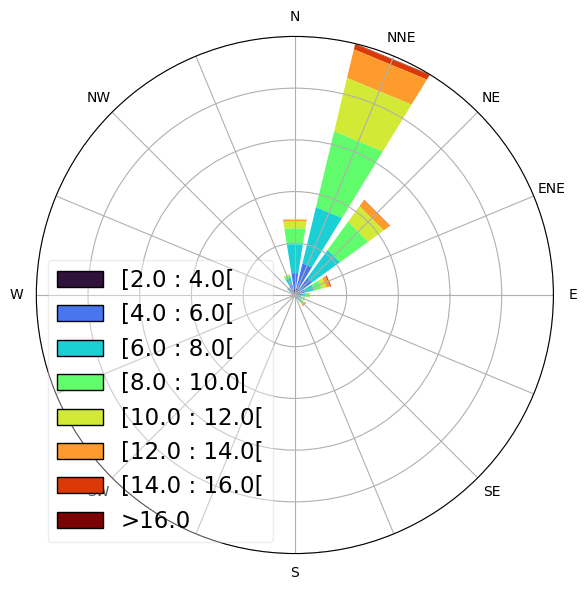

In [40]:
plt.style.use("default")
# plt.style.use('dark_background')
# ------------------------------------------------------------------------------

fig = plt.figure(figsize=(6, 6))

# sns.set_theme()
# sns.set_style("whitegrid")
# sns.color_palette("husl", 8)
# sns.color_palette("tab10")
# sns.set_context("talk")
# fig.suptitle(f"{period}", fontsize=25)
# plt.axis('off')

labels = [
    "E",
    "ENE",
    "NE",
    "NNE",
    "N",
    "NNW",
    "NW",
    "WNW",
    "W",
    "WSW",
    "SW",
    "SSW",
    "S",
    "SSE",
    "SE",
    "ESE",
]

ax1 = fig.add_subplot(111, projection="windrose")
ax1.set_thetagrids(
    angles=np.arange(0, 360, 22.5),
    labels=[
        "E",
        "ENE",
        "NE",
        "NNE",
        "N",
        "",
        "NW",
        "",
        "W",
        "",
        "SW",
        "",
        "S",
        "",
        "SE",
        "",
    ],
)

ax1.bar(
    met_df.met_WinddirectionRot_mean,
    met_df.met_WindSpeedRot_mean,
    normed=True,
    opening=0.8,
    edgecolor="None",
    bins=np.arange(2, 18, 2),
    cmap=cm.turbo,
)

# ax1.legend(title="Wind Speed")
ax1.legend(prop={"size": 16.5}, framealpha=0.35)
ax1.set_yticklabels([])


# ax2 = fig.add_subplot(121)
# font_size = 12
# bbox = [0.1, 0.2, 0.8, 0.6]
# ax2.axis("off")
# #
# mpl_table = ax2.table(cellText=met.values, bbox=bbox, colLabels=met.columns)
# mpl_table.auto_set_font_size(True)
# mpl_table.set_fontsize(font_size)


fig.tight_layout()
fig.savefig(f"./input/{period}/{period}-A-rose.svg", transparent=True)


plt.show()

## Speed bins

In [41]:
bj = np.arange(0, 25 + 1, 2)
bj

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24])

In [42]:
met_df.loc[:, "Vitesse"] = pd.cut(met_df.met_WindSpeedRot_mean, bj)

# met_df["Vitesse"] = met_df["Vitesse"].apply(lambda x: x.mid)
met_df

,met_WindSpeedRot_mean,met_WinddirectionRot_mean,Vitesse
TimeStamp,,,
2023-01-01 00:00:00,7.468824,154.003457,"(6, 8]"
2023-01-01 00:10:00,6.882876,154.246184,"(6, 8]"
2023-01-01 00:20:00,6.770496,153.831039,"(6, 8]"
2023-01-01 00:30:00,7.150853,153.331045,"(6, 8]"
2023-01-01 00:40:00,6.952206,152.190521,"(6, 8]"
...,...,...,...
2023-12-31 23:20:00,6.875553,77.707393,"(6, 8]"
2023-12-31 23:30:00,7.057068,78.885951,"(6, 8]"
2023-12-31 23:40:00,7.203598,76.178476,"(6, 8]"


In [43]:
(100 * met_df.groupby("Vitesse").count() / len(met_df)).round()

,met_WindSpeedRot_mean,met_WinddirectionRot_mean
Vitesse,,
"(0, 2]",1.0,1.0
"(2, 4]",6.0,6.0
"(4, 6]",16.0,16.0
"(6, 8]",26.0,26.0
"(8, 10]",25.0,25.0
"(10, 12]",16.0,16.0
"(12, 14]",8.0,8.0
"(14, 16]",1.0,1.0
"(16, 18]",0.0,0.0


# #4 Durée et frequence par categorie d'alarme

In [51]:
df_ax4 = (
    cumul_main_result_sum.groupby("Error Group")
    .agg(
        **{
            "Freq": ("Alarmcode", "count"),
            "Durée arrêts": ("RealPeriod", lambda x: x.sum().total_seconds() / 3600),
        }
    )
    .reindex(reorder)
    .dropna()
    .reset_index()
)

# df_ax4.plot(kind='bar', x='Error Group', ax=ax5)
df_ax4.to_clipboard(index=False, decimal=",", sep=",")

df_ax4

,Error Group,Freq,Durée arrêts
0,System,9607.0,28563.065508
1,Generator,161.0,76.656111
2,Hub,11398.0,2340.686691
3,Gear,310.0,799.943639
4,Grid,271.0,828.214722
5,Rotor,102.0,116.562778
6,Hydraulics,1476.0,1570.782444
7,Environement,153.0,40.579444
8,Brake,1257.0,317.101250
9,Yaw,5399.0,1800.719486


# #5 MTBF et MTTR par catégorie d'alarme

In [31]:
MTBF_MTTR_cat = (
    cumul_main_result_sum.query(mt_query, engine="python")
    .groupby("Error Group")
    .agg(Durée=("RealPeriod", lambda x: x.sum().total_seconds() / 3600), Freq=("TimeOn", "count"))
    .rename_axis("Catégorie")
    .sort_values("Freq", ascending=False)
    .reindex(reorder)
    .dropna()
    .reset_index()
)

duree_cumul = MTBF_MTTR_cat["Durée"]
freq_cumul = MTBF_MTTR_cat["Freq"]

MTBF_MTTR_cat["MTTR en h"] = duree_cumul / freq_cumul

MTBF_MTTR_cat["MTBF en j"] = ((days_in_cumul * 24 * 131) - duree_cumul) / (freq_cumul * 24)

MTBF_MTTR_cat["1 / (MTBF en j)"] = 1e3 / (((days_in_cumul * 24 * 131) - duree_cumul) / (freq_cumul * 24))

MTBF_MTTR_cat = MTBF_MTTR_cat.round(2)

MTBF_MTTR_cat

,Catégorie,Durée,Freq,MTTR en h,MTBF en j,1 / (MTBF en j)
0,System,639.85,44.0,14.54,1086.10,0.92
1,Generator,25.61,4.0,6.40,11953.48,0.08
2,Hub,973.64,119.0,8.18,401.47,2.49
3,Gear,719.26,78.0,9.22,612.63,1.63
4,Grid,804.18,98.0,8.21,487.57,2.05
5,Rotor,85.08,13.0,6.54,3677.80,0.27
6,Hydraulics,1445.13,144.0,10.04,331.63,3.02
7,Environement,6.13,2.0,3.07,23907.37,0.04
8,Brake,230.70,27.0,8.54,1770.57,0.56
9,Yaw,672.54,97.0,6.93,492.65,2.03


In [71]:
df_ax5 = MTBF_MTTR_cat[["Catégorie", "MTTR en h", "1 / (MTBF en j)"]]
# df_ax5.rename(columns={'MTTR en h': 'MTTR', 'MTBF en j': 'MTBF'}, inplace=True)

df_ax5.to_clipboard(index=False, decimal=",", sep=",")
df_ax5

,Catégorie,MTTR en h,1 / (MTBF en j)
0,System,14.54,0.92
1,Generator,6.40,0.08
2,Hub,8.18,2.49
3,Gear,9.22,1.63
4,Grid,8.21,2.05
5,Rotor,6.54,0.27
6,Hydraulics,10.04,3.02
7,Environement,3.07,0.04
8,Brake,8.54,0.56
9,Yaw,6.93,2.03


# #6 Durée et fréquence par code d'alarme

In [72]:
df_ax6 = (
    cumul_main_result_sum.groupby(["UK Text", "Alarmcode"])
    .agg(
        **{
            "Freq": ("Alarmcode", "count"),
            "Arrêts TAREC": ("RealPeriod", lambda x: x.sum().total_seconds() / 3600),
            "Type": ("Error Type", "first"),
        }
    )
    .sort_values("Arrêts TAREC", ascending=False)
    .head(20)
    .reset_index()
)

df_ax6.loc[df_ax6.Type == 1, "Arrêts SGRE"] = df_ax6.loc[df_ax6.Type == 1, "Arrêts TAREC"]
df_ax6.loc[df_ax6.Type == 1, "Arrêts TAREC"] = np.nan
df_ax6.drop(columns="Type", inplace=True)

# df_ax6.plot(kind='bar', x='Alarmcode', ax=ax6)
df_ax6.to_clipboard(index=False, decimal=",", sep=",")
df_ax6

,UK Text,Alarmcode,Freq,Arrêts TAREC,Arrêts SGRE
0,Manual stop,1001,5543,NaN,16307.877385
1,Remote stop - Owner,1007,705,6335.551111,NaN
2,Manual idle stop - yawing,1025,1738,NaN,4573.864767
3,"Converter trip, external",13911,10,NaN,2584.822778
4,Main breaker tripped,64066,56,NaN,1425.511667
5,Hyd oil level error,7101,890,NaN,1310.426333
6,Pitch functionality check,3130,8819,788.175278,NaN
7,"Converter tripped, general",13900,196,NaN,758.698429
8,DC fuse blown,13110,18,NaN,654.500556
9,Converter cooling dryer mode,13294,42,NaN,649.029444


# #7 Durée et fréquence des arrets par turbine

In [73]:
df_ax7 = (
    pd.merge(
        (
            cumul_results.query("wtc_ActPower_min <= 0")
            .groupby("StationId")
            .agg(
                **{
                    "Durée arrêts": ("RealPeriod", lambda x: x.sum() / 3600),
                    "Durée autres": ("Duration 20-25(s)", lambda x: x.sum() / 3600),
                }
            )
            .reset_index()
        ),
        (
            cumul_alarms.groupby("StationId")
            .agg(
                **{
                    "Freq arrêts": (
                        "Alarmcode",
                        lambda x: int(x[x == 115].count() / 2),
                    ),
                    "Freq autres": ("Alarmcode", lambda x: x[x == 20].count()),
                }
            )
            .reset_index()
        ),
    )
    .sort_values("Durée arrêts", ascending=False)
    .head(20)
)

# df_ax7.plot(kind='bar', x='StationId', ax=ax8)

# for stacked bar excel chart
df_ax7["Duration_20_25 reel"] = df_ax7["Durée autres"]
df_ax7["Durée autres"] = df_ax7["Duration_20_25 reel"] - df_ax7["Durée arrêts"]

df_ax7.to_clipboard(index=False, decimal=",", sep=",")
df_ax7

,StationId,Durée arrêts,Durée autres,Freq arrêts,Freq autres,Duration_20_25 reel
62,63.0,2419.165000,-1975.207500,130,904,443.957500
48,49.0,1750.710022,271.214978,186,1221,2021.925000
53,54.0,804.149167,304.309167,251,1080,1108.458333
1,2.0,776.064194,186.661639,205,836,962.725833
126,127.0,773.705278,315.486389,171,1661,1089.191667
9,10.0,769.749444,238.128611,214,1258,1007.878056
94,95.0,744.699722,317.670556,174,1143,1062.370278
67,68.0,702.295319,308.643014,213,1188,1010.938333
120,121.0,697.591389,320.274444,251,1293,1017.865833
84,85.0,676.824444,370.536389,243,1533,1047.360833


# #9 Energie perdue en MWh

In [75]:
df_ax9 = (
    cumul_results[["StationId", "ELNX", "ELX", "EL_indefini_left", "EL_Misassigned"]]
    .groupby("StationId")
    .sum()
    .sort_values("StationId")
    # .head(20)
    .reset_index()
)

df_ax9["ELNX"] = df_ax9["ELNX"] + df_ax9["EL_Misassigned"]
df_ax9["ELX"] = df_ax9["ELX"] - df_ax9["EL_Misassigned"]

df_ax9[["ELNX", "ELX", "EL_indefini_left", "EL_Misassigned"]] = (
    df_ax9[["ELNX", "ELX", "EL_indefini_left", "EL_Misassigned"]] / 1e3
)

df_ax9.rename({"ELNX": "Energie perdue SGRE", "ELX": "Energie perdue TAREC"}, inplace=True, axis=1)

df_ax9 = df_ax9.round(2)

df_ax9.to_clipboard(index=False, decimal=",", sep=",")
df_ax9

,StationId,Energie perdue SGRE,Energie perdue TAREC,EL_indefini_left,EL_Misassigned
0,1,21.420000,1.35,0.00,0.00
1,2,54.490002,1.82,0.00,2.38
2,3,55.150002,3.28,0.00,1.79
3,4,27.780001,1.53,0.08,2.02
4,5,55.110001,2.92,0.00,2.06
...,...,...,...,...,...
126,127,3.530000,0.84,0.28,0.14
127,128,0.000000,0.70,0.00,0.00
128,129,55.849998,0.76,0.00,0.00
129,130,0.000000,0.79,0.00,0.00


# #13 Énergie consommée

## Par turbine

In [77]:
cumul_results.groupby(cumul_results.TimeStamp.dt.to_period("M")).sum(numeric_only=True)[["wtc_kWG1TotI_accum"]].reset_index().sum()

C:\Users\saada\AppData\Local\Temp\ipykernel_24028\3724461552.py:1: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  cumul_results.groupby(cumul_results.TimeStamp.dt.to_period("M")).sum(numeric_only=True)[["wtc_kWG1TotI_accum"]].reset_index().sum()


wtc_kWG1TotI_accum    1347244.0
dtype: float64

In [88]:
from sys import maxsize

# from turtle import title
import plotly.express as px

fig = px.scatter_mapbox(
    (cumul_results.groupby("StationId").sum(numeric_only=True)[["wtc_kWG1TotI_accum"]] / 1e3)
    .reset_index()
    .merge(df_coords, on="StationId", how="left"),
    lat="lat",
    lon="lon",
    hover_name="StationId",
    # hover_data=["wtc_AcWindSp_mean"],
    color="wtc_kWG1TotI_accum",
    color_continuous_scale="Turbo",
    # size_max=100,
    zoom=11.7,
    height=850,
    width=1000,
    title="x",
    center={"lat": 27.7787632, "lon": -12.9051846},
    labels={"wtc_kWG1TotI_accum": "Conso MWh"},
)

title = "Énergie consommée par turbine"
fig.update_layout(
    mapbox_style="open-street-map",
    title={"text": title, "x": 0.5, "xref": "paper", "font": dict(size=20)},
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)",
)
fig.update_layout(margin={"r": 0, "t": 30, "l": 0, "b": 0})

fig.update_traces(
    marker=dict(
        size=14,
    )
)


fig.update_geos(projection_type="orthographic")

fig.show()
# fig.write_html("Vitesse moyenne Turbines Janvier à Décembre 2022.html")
fig.write_image(f"./input/{period}/{title}-A.svg")

# #14 Boost

In [42]:
def read_boost(period):
    usecols_cnt = """TimeStamp, StationId, wtc_BoostKWh_endvalue, wtc_BostkWhS_endvalue"""

    sql_cnt = f"Select {usecols_cnt} FROM tblSCTurCount;"

    cnt = zip2mdb2df(data_type="CNT", sql=sql_cnt, period=period)

    cnt["TimeStamp"] = pd.to_datetime(cnt["TimeStamp"], format="%m/%d/%y %H:%M:%S")

    return cnt


def boost_endvalue_check(df):
    df = df.reset_index().sort_values("TimeStamp")
    df.drop("index", axis=1, inplace=True)
    clmn = df["wtc_BoostKWh_endvalue"]
    x = (clmn.iat[-1] - clmn.iat[0]) / 1000
    # df = df.diff().query('wtc_BoostKWh_endvalue < 0')
    return max(x, 0)

In [43]:
# last_boost_cumul = input('last_boost_cumul') or 3458.1

boost = read_boost(period)
boost["StationId"] = boost["StationId"] - 2307404

boost_period = boost.groupby("StationId").apply(lambda df: boost_endvalue_check(df)).sum()


if period_month == 1:
    boost_cumul = boost_period
else:
    boost_cumul = last_boost_cumul + boost_period

2024-01-23 15:21:34,362 INFO sqlalchemy.engine.Engine Select TimeStamp, StationId, wtc_BoostKWh_endvalue, wtc_BostkWhS_endvalue FROM tblSCTurCount;
2024-01-23 15:21:34,362 INFO sqlalchemy.engine.Engine [raw sql] ()


In [44]:
boost_period, boost_cumul

(275.5264375, 11599.1064375)

## Per turbine/month

In [81]:
boost_cumul_df = pd.DataFrame()

for month in range(1, period_month + 1):  # range(1, period_month+1):

    period_cumul = f"{str(period_year).zfill(2)}-{str(month).zfill(2)}"

    # -------------------------------------------------------------------------
    boost_cumul_df = pd.concat([boost_cumul_df, read_boost(period_cumul)])

boost_cumul_df["StationId"] = boost_cumul_df["StationId"] - 2307404


2024-01-23 15:37:10,957 INFO sqlalchemy.engine.Engine Select TimeStamp, StationId, wtc_BoostKWh_endvalue, wtc_BostkWhS_endvalue FROM tblSCTurCount;
2024-01-23 15:37:10,957 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-01-23 15:37:16,838 INFO sqlalchemy.engine.Engine Select TimeStamp, StationId, wtc_BoostKWh_endvalue, wtc_BostkWhS_endvalue FROM tblSCTurCount;
2024-01-23 15:37:16,839 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-01-23 15:37:22,150 INFO sqlalchemy.engine.Engine Select TimeStamp, StationId, wtc_BoostKWh_endvalue, wtc_BostkWhS_endvalue FROM tblSCTurCount;
2024-01-23 15:37:22,151 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-01-23 15:37:28,544 INFO sqlalchemy.engine.Engine Select TimeStamp, StationId, wtc_BoostKWh_endvalue, wtc_BostkWhS_endvalue FROM tblSCTurCount;
2024-01-23 15:37:28,545 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-01-23 15:37:37,498 INFO sqlalchemy.engine.Engine Select TimeStamp, StationId, wtc_BoostKWh_endvalue, wtc_BostkWhS_endvalue FROM tblSCTu

### Turbine

In [84]:
boost_turbine_cumul_df = boost_cumul_df.groupby("StationId").apply(lambda df: boost_endvalue_check(df))

boost_turbine_cumul_df = boost_turbine_cumul_df.to_frame().merge(df_coords, on="StationId", how="left")
boost_turbine_cumul_df.rename(columns={0: "Boost MWh"}, inplace=True)
boost_turbine_cumul_df

,StationId,Boost MWh,lat,lon
0,1,118.548812,27.851773,-12.890785
1,2,99.338000,27.850717,-12.887961
2,3,116.047906,27.849768,-12.885450
3,4,116.667375,27.848848,-12.882779
4,5,115.831500,27.847700,-12.880139
...,...,...,...,...
126,127,67.234188,27.724365,-12.926529
127,128,64.721187,27.725363,-12.929147
128,129,61.988703,27.726360,-12.931722
129,130,67.747500,27.727366,-12.934350


In [87]:
boost_turbine_cumul_df["Boost MWh"].sum()

10845.281118652343

In [86]:
from sys import maxsize

# from turtle import title
import plotly.express as px

fig = px.scatter_mapbox(
    boost_turbine_cumul_df,
    lat="lat",
    lon="lon",
    hover_name="StationId",
    # hover_data=["wtc_AcWindSp_mean"],
    color="Boost MWh",
    color_continuous_scale="Turbo",
    # size_max=100,
    zoom=11.7,
    height=850,
    width=1000,
    title="x",
    center={"lat": 27.7787632, "lon": -12.9051846},
    range_color=[0, boost_turbine_cumul_df["Boost MWh"].max()]
)

title = "Boost par Turbine"
fig.update_layout(
    mapbox_style="open-street-map",
    title={"text": title, "x": 0.5, "xref": "paper", "font": dict(size=20)},
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)",
)
fig.update_layout(margin={"r": 0, "t": 30, "l": 0, "b": 0})

fig.update_traces(
    marker=dict(
        size=14,
    )
)


fig.update_geos(projection_type="orthographic")

fig.show()
# fig.write_html("Vitesse moyenne Turbines Janvier à Décembre 2022.html")
fig.write_image(f"./input/{period}/{title}-A.svg")

### Month

In [108]:
boost_month = (
    boost_cumul.groupby(boost_cumul.TimeStamp.dt.to_period("M"))
    .apply(
        lambda boost_cumul: boost_cumul.groupby("StationId").apply(lambda df: boost_endvalue_check(df)).sum()
    )
    .to_frame()
)
boost_month

,0
TimeStamp,
2023-01,805.765859
2023-02,384.827953
2023-03,958.051281
2023-04,1003.557994
2023-05,1323.846422
2023-06,385.677609
2023-07,3661.819416
2023-08,1733.714469
2023-09,94.221844
